<h3>Data</h3>
<br>
File name format&nbsp;&nbsp;: 
Year + Quarter. e.g. 2010Q1 is first quarter in year 2010. The files are in CSV format.
<br>
Total dataset&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: 
46, from year 2010 - 2021 with an exception only Q1 and Q2 in year 2021.
<br>
Labels&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: 
Vary (1000 - 3000 rows).
<br>
Features&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;:
7

<h3> Features Description </h3>
<br>
Date&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;:
The date of the sales (YY-mm-dd).
<br>
Category1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;:
First word of the item category.
<br>
Category2&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;:
Second word of the item category.
<br>
Category3&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;:
Third word of the item category.
<br>
Maker&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;:
The name of the item maker
<br>
Sales&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;:
Number of sales
<br>
Identifier&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;:
Item ID

<h3>Objective(s)</h3>
<br>
<li> Data cleaning and preprocessing </li>
<li> Data modeling (forecasting)</li>
<li> Decision making</li>

# Data Cleaning and Preprocessing

**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

**Load the data**

In [2]:
path = 'D:/complete-proj/2021/07/apply/ilmuone-data/dataset'
all_files = glob.glob('dataset' + '/*.csv')

In [3]:
lst = []
for filename in all_files:
    # Read the data
    data = pd.read_csv(filename, index_col=None, header=0)
    
    # Fill the missing Sales data
    grpby_id = data.groupby(by='Identifier').mean().round(2)
    for identifier, sales_mean in zip(grpby_id.index, grpby_id.values):
        data['Sales'] = data['Sales'].mask((data['Sales'].isnull()) & (data['Identifier'] == identifier), sales_mean)

    # Exclude certain Identifiers
    data = data[~data['Identifier'].str.contains(r'[0-9]')]
    
    lst.append(data)

In [4]:
df = pd.concat(lst, axis=0, ignore_index=True)

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df

,Date,Category1,Category2,Category3,Maker,Sales,Identifier
0,2010-02-15,Air,Conditioners,NaN,Toshino,2143.0,RVFWTWSMNU
1,2010-02-15,Washers,&,Dryers,Akaza,3515.0,VUQUQMHODG
2,2010-02-15,Refrigerators,NaN,NaN,Akaza,687.0,XVIOZZOUTN
3,2010-02-15,Washers,&,Dryers,Shimada,435.0,RBRMDIXXGL
4,2010-02-15,Refrigerators,NaN,NaN,Funami,726.0,BIBIOOIHA
...,...,...,...,...,...,...,...
93166,2021-04-29,Ovens,&,Cooktops,Shimada,1258.0,WVJTPVZKAQ
93167,2021-04-29,Washers,&,Dryers,Akaza,5422.0,VUQUQMHODG
93168,2021-04-29,Vacuum,Cleaners,NaN,Hayashida,539.0,GCPKFKSEWG
93169,2021-04-29,Water,Pumps,NaN,Furutani,10547.0,FVDHIZGQRC


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93171 entries, 0 to 93170
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        93171 non-null  datetime64[ns]
 1   Category1   93171 non-null  object        
 2   Category2   63428 non-null  object        
 3   Category3   19474 non-null  object        
 4   Maker       93171 non-null  object        
 5   Sales       93171 non-null  float64       
 6   Identifier  93171 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 5.0+ MB


**Combine the words in `Category1`, `Category2`, and `Category3` into one column `Category`**

In [8]:
df['Category'] = np.nan

In [9]:
bool_cat2isnull_cat3isnull = (df['Category2'].isnull()) & (df['Category3'].isnull())
bool_cat2notnull_cat3isnull = (df['Category2'].notnull()) & (df['Category3'].isnull())
bool_cat2notnull_cat3notnull = (df['Category2'].notnull()) & (df['Category3'].notnull())

In [10]:
df['Category'] = df['Category'].mask(bool_cat2isnull_cat3isnull, df['Category1'])
df['Category'] = df['Category'].mask(bool_cat2notnull_cat3isnull, df['Category1'] + ' ' + df['Category2'])
df['Category'] = df['Category'].mask(bool_cat2notnull_cat3notnull, df['Category1'] + ' ' + df['Category2'] + ' ' + df['Category3'])

In [11]:
df = df.drop(['Category1', 'Category2', 'Category3'], axis=1)

In [12]:
df = df[['Date', 'Category', 'Maker', 'Sales', 'Identifier']]

In [13]:
df.head()

,Date,Category,Maker,Sales,Identifier
0,2010-02-15,Air Conditioners,Toshino,2143.0,RVFWTWSMNU
1,2010-02-15,Washers & Dryers,Akaza,3515.0,VUQUQMHODG
2,2010-02-15,Refrigerators,Akaza,687.0,XVIOZZOUTN
3,2010-02-15,Washers & Dryers,Shimada,435.0,RBRMDIXXGL
4,2010-02-15,Refrigerators,Funami,726.0,BIBIOOIHA


In [14]:
df.isnull().sum()

Date          0
Category      0
Maker         0
Sales         0
Identifier    0
dtype: int64

**Save to a new file**

In [15]:
df.to_csv('dataset-clean.csv', index=False)

# Data Modeling (Forecasting)

**Groupby `Date` and interpolate**

In [16]:
ts = pd.read_csv('dataset-clean.csv') # ts = time series
ts['Date'] = pd.to_datetime(ts['Date'])
ts = ts.groupby(by='Date').sum()

In [17]:
ts

,Sales
Date,
2010-02-15,92680.57
2010-02-16,91157.83
2010-02-17,92596.33
2010-02-18,90822.00
2010-02-19,90028.21
...,...
2021-04-23,142664.00
2021-04-26,141279.35
2021-04-27,140634.53


In [18]:
ts = ts.asfreq('D')
ts['Sales'] = ts['Sales'].interpolate()

In [19]:
ts

,Sales
Date,
2010-02-15,92680.57
2010-02-16,91157.83
2010-02-17,92596.33
2010-02-18,90822.00
2010-02-19,90028.21
...,...
2021-04-25,141740.90
2021-04-26,141279.35
2021-04-27,140634.53


<AxesSubplot:xlabel='Date'>

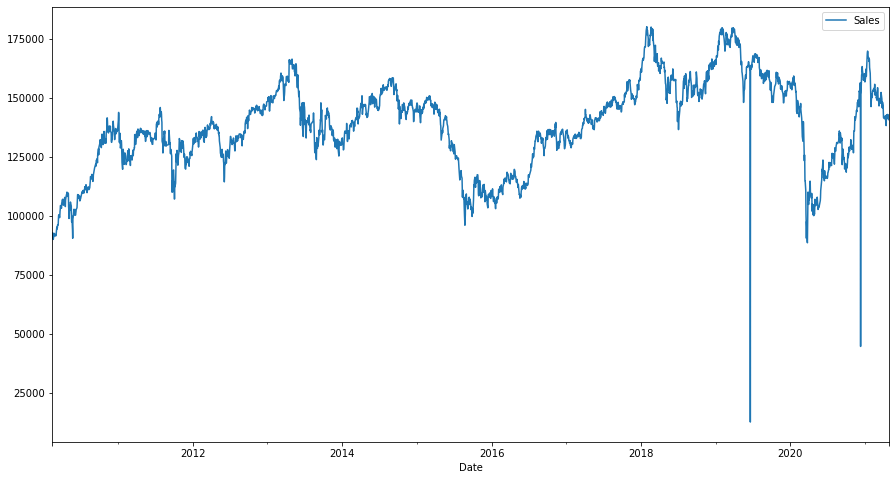

In [20]:
ts.plot(figsize=(15, 8))

**Build the model**

In [21]:
train = ts.iloc[:len(ts)-12]
test = ts.iloc[len(ts)-12:]

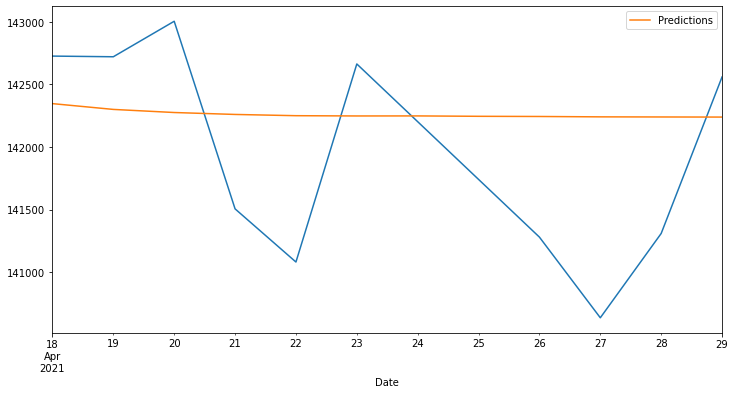

In [22]:
model = SARIMAX(train['Sales'], order=(1, 1, 2), seasonal_order=(1, 0, 1, 24))
results = model.fit()

start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start=start, end=end, typ='levels').rename('Predictions')

ax = test['Sales'].plot(figsize=(12, 6))
predictions.plot(legend=True)
ax.autoscale(axis='x', tight=True)

In [23]:
error1 = mean_squared_error(test['Sales'], predictions)
error2 = rmse(test['Sales'], predictions)
print('MSE Error: {:11.10}'.format(error1))
print('RMSE Error: {:11.10}'.format(error2))

MSE Error: 642071.4722
RMSE Error: 801.2936242


In [24]:
model = SARIMAX(train['Sales'], order=(1, 1, 2), seasonal_order=(1, 0, 1, 24))
results = model.fit()
fcast = results.predict(len(ts), len(ts)+30, typ='levels').rename('Predictions')

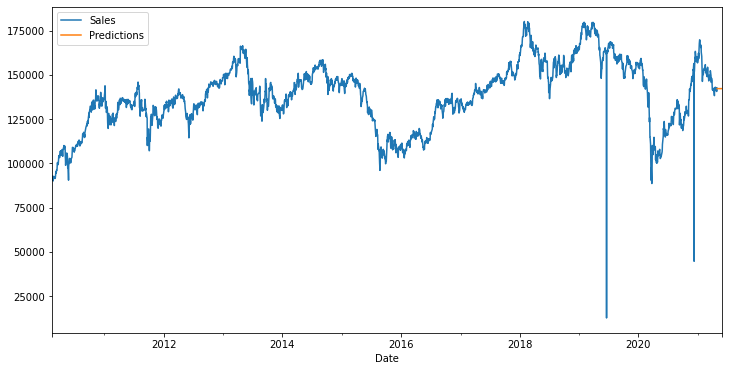

In [25]:
ax = ts['Sales'].plot(legend=True,figsize=(12,6))
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)

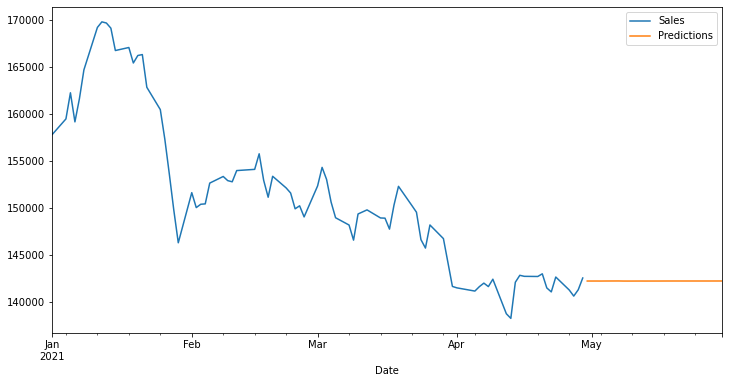

In [26]:
ax = ts.loc['2021-01-01':'2021-04-29']['Sales'].plot(legend=True,figsize=(12,6))
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [27]:
fcast.mean()

142239.39886065503

In [28]:
ts

,Sales
Date,
2010-02-15,92680.57
2010-02-16,91157.83
2010-02-17,92596.33
2010-02-18,90822.00
2010-02-19,90028.21
...,...
2021-04-25,141740.90
2021-04-26,141279.35
2021-04-27,140634.53


**30 million sales prediction**

In [29]:
total_2021_sales = 11849286
fcast_mean = 142239.41

In [30]:
30000000 - 11849286

18150714

In [31]:
18150714 / fcast_mean

127.60678633298605

In [32]:
total_days = 128

In [33]:
from datetime import datetime, timedelta
s = '2021-04-29' # Last data input date
date = datetime.strptime(s, '%Y-%m-%d')

In [34]:
modified_date = date + timedelta(days=total_days)

In [35]:
datetime.strftime(modified_date, '%Y-%m-%d')

'2021-09-04'

# Decision Making

**Create a pivot table on `Maker` column**

In [36]:
pvt = pd.read_csv('dataset-clean.csv') # pvt = pivot table
pvt['Date'] = pd.to_datetime(pvt['Date'])
pvt_maker = pd.pivot_table(pvt, values='Sales', index='Date', columns=['Maker'], aggfunc=np.sum)

In [37]:
pvt_maker.head()

Maker,Akaza,Funami,Furutani,Hayashida,Hisami,Ikeda,Katayama,Kikuma,Matsumoto,Nanase,Okamoto,Omuro,Shimada,Sugiura,Toshino,Yoshikawa
Date,,,,,,,,,,,,,,,,
2010-02-15,4544.00,14929.0,10014.0,134.0,749.0,562.0,1517.0,NaN,425.0,4011.0,322.0,38504.57,2388.0,3908.00,8919.00,1754.0
2010-02-16,4572.00,15464.0,10122.0,136.0,758.0,586.0,1549.0,NaN,427.0,4197.0,316.0,35678.00,2413.0,4009.83,9138.00,1792.0
2010-02-17,4665.00,15860.0,10146.0,139.0,753.0,569.0,1549.0,NaN,419.0,4246.0,307.0,36282.00,2413.0,4045.00,9442.33,1761.0
2010-02-18,4615.00,15436.0,10072.0,139.0,756.0,567.0,1517.0,NaN,409.0,4167.0,316.0,35437.00,2364.0,3997.00,9233.00,1797.0
2010-02-19,4668.21,15405.0,9946.0,133.0,758.0,570.0,1465.0,NaN,423.0,4145.0,317.0,34852.00,2354.0,3946.00,9262.00,1784.0


<AxesSubplot:xlabel='Date'>

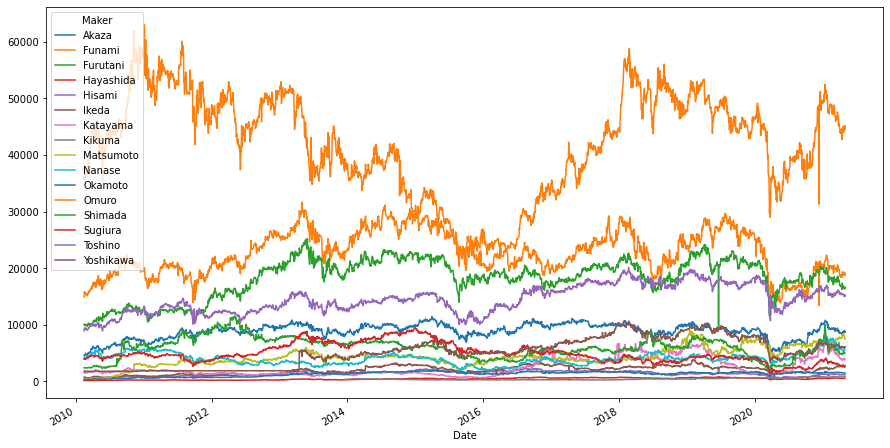

In [38]:
pvt_maker.plot(figsize=(15, 8))

**Filter the bottom 3 maker**

In [39]:
pvt_maker_tail3 = pvt_maker.drop(['Omuro', 'Funami', 'Furutani',
                                  'Hayashida', 'Toshino', 'Akaza',
                                  'Shimada', 'Yoshikawa', 'Sugiura',
                                  'Matsumoto', 'Katayama', 'Nanase', 'Ikeda'],axis=1)

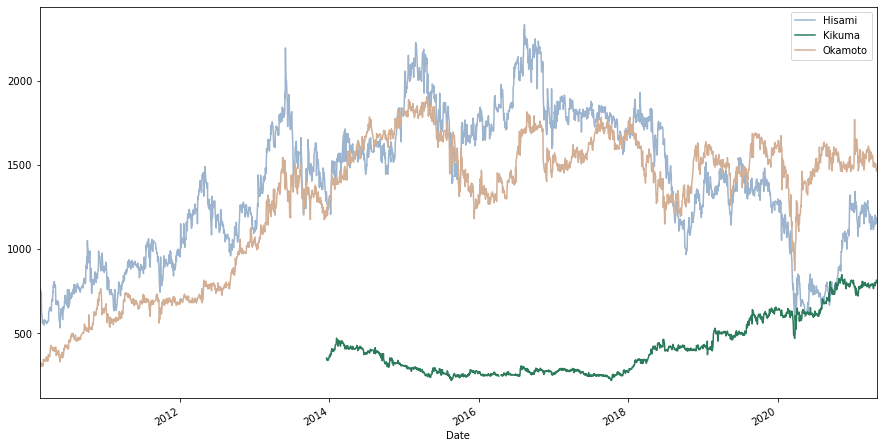

In [40]:
ax1 = pvt_maker_tail3['Hisami'].plot(legend=True, figsize=(15, 8), color='#9cb4ce')
ax1.autoscale(axis='x', tight=True)

ax2 = pvt_maker_tail3['Kikuma'].plot(legend=True, figsize=(15, 8), color='#2c7c5b')
ax2.autoscale(axis='x', tight=True)

ax3 = pvt_maker_tail3['Okamoto'].plot(legend=True, figsize=(15, 8), color='#d3af95')
ax3.autoscale(axis='x', tight=True)

**Forecast for each maker**

In [41]:
pvt_maker_tail3 = pvt_maker_tail3.asfreq('D')

In [42]:
pvt_maker_tail3['Hisami'] = pvt_maker_tail3['Hisami'].interpolate()
pvt_maker_tail3['Okamoto'] = pvt_maker_tail3['Okamoto'].interpolate()
pvt_maker_tail3['Kikuma'] = pvt_maker_tail3['Kikuma'].interpolate().fillna(0)

In [43]:
train = pvt_maker_tail3.iloc[:len(pvt_maker_tail3)-12]
model1 = SARIMAX(train['Hisami'], order=(1, 1, 2), seasonal_order=(1, 0, 1, 24))
results1 = model1.fit()
fcast1 = results1.predict(len(pvt_maker_tail3), len(pvt_maker_tail3)+30, typ='levels').rename('Hisami Prediction')

In [44]:
model2 = SARIMAX(train['Kikuma'], order=(1, 1, 2), seasonal_order=(1, 0, 1, 24))
results2 = model2.fit()
fcast2 = results2.predict(len(pvt_maker_tail3), len(pvt_maker_tail3)+30, typ='levels').rename('Kikuma Prediction')

In [45]:
model3 = SARIMAX(train['Okamoto'], order=(1, 1, 2), seasonal_order=(1, 0, 1, 24))
results3 = model3.fit()
fcast3 = results3.predict(len(pvt_maker_tail3), len(pvt_maker_tail3)+30, typ='levels').rename('Okamoto Prediction')

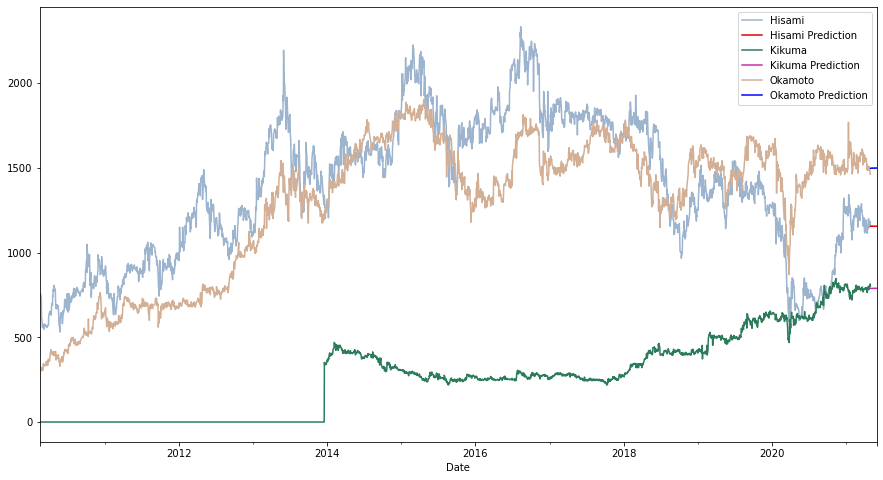

In [46]:
ax1 = pvt_maker_tail3['Hisami'].plot(legend=True, figsize=(15, 8), color='#9cb4ce')
fcast1.plot(legend=True, color='#e10101')
ax1.autoscale(axis='x', tight=True)

ax2 = pvt_maker_tail3['Kikuma'].plot(legend=True, figsize=(15, 8), color='#2c7c5b')
fcast2.plot(legend=True, color='#c92ba7')
ax2.autoscale(axis='x', tight=True)

ax3 = pvt_maker_tail3['Okamoto'].plot(legend=True, figsize=(15, 8), color='#d3af95')
fcast3.plot(legend=True, color='#0000ff')
ax3.autoscale(axis='x', tight=True)

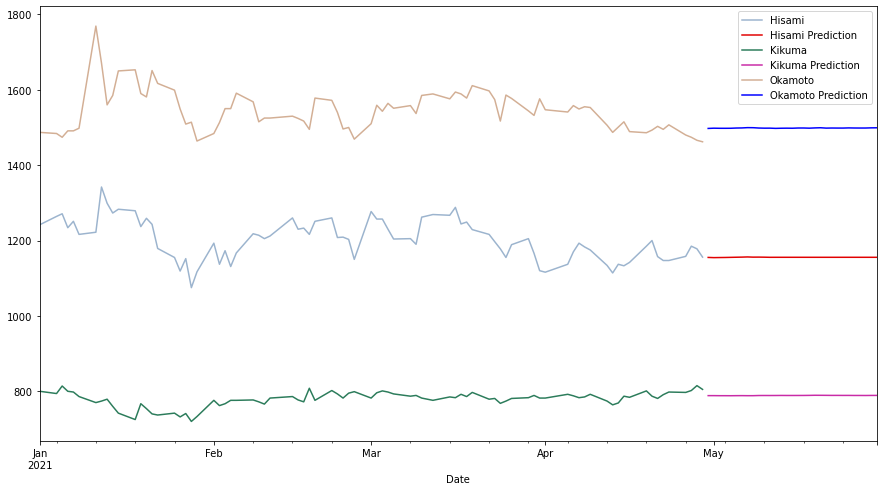

In [54]:
ax1 = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Hisami'].plot(legend=True, figsize=(15, 8), color='#9cb4ce')
fcast1.plot(legend=True, color='#e10101')
ax1.autoscale(axis='x', tight=True)

ax2 = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Kikuma'].plot(legend=True, figsize=(15, 8), color='#2c7c5b')
fcast2.plot(legend=True, color='#c92ba7')
ax2.autoscale(axis='x', tight=True)

ax3 = pvt_maker_tail3.loc['2021-01-01':'2021-04-29']['Okamoto'].plot(legend=True, figsize=(15, 8), color='#d3af95')
fcast3.plot(legend=True, color='#0000ff')
ax3.autoscale(axis='x', tight=True)

**Each maker's attributes**

Forecast mean

In [48]:
fcast1.mean() # Hisami

1155.5197074057742

In [49]:
fcast2.mean() # Kikuma

788.804163804821

In [50]:
fcast3.mean() # Okamoto

1498.4237634023275

Main category

In [51]:
df['Category'][(df['Maker'] == 'Hisami') & (df['Date'].dt.year == 2021)].value_counts()

Vacuum Cleaners    81
Name: Category, dtype: int64

In [52]:
df['Category'][(df['Maker'] == 'Kikuma') & (df['Date'].dt.year == 2021)].value_counts()

Televisions    81
Name: Category, dtype: int64

In [53]:
df['Category'][(df['Maker'] == 'Okamoto') & (df['Date'].dt.year == 2021)].value_counts()

Televisions    81
Name: Category, dtype: int64

# Thank You